##Generative Adversarial Networks(GANs)



**The goal of this notebook is to implement GANs.**
This notebook is adapted from https://github.com/Yangyangii/GAN-Tutorial



##Setup

**Mount on google drive**
you can skip this cell if you prefer

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)
Folder_name = 'tasks' # to be changed according to the folder you place the notebook in
assert Folder_name is not None, "[1] Enter the folder name"

import sys
sys.path.append('content/drive/MyDrive/{}'.format(Folder_name))
%cd drive/MyDrive/$Folder_name/


Mounted at /content/drive
/content/drive/MyDrive/tasks


**Check GPU**

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


**Imports**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import os, sys


##Dataset

**Create a Custom dataset**

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image, label = self.data[index]
        if self.transform:
            image = self.transform(image)
        return image, label

# apply a transformation on the dataset to get an image of size image_size * image_size
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)



**Use the MNIST dataset**

In [ ]:
batch_size = 64

mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
total_size = len(mnist)*0.8
training_indices = range(int(total_size))
selected_mnist_trainset = torch.utils.data.Subset(mnist, training_indices)
custom_dataset_train = CustomDataset(mnist)
dataloader_train = DataLoader(custom_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)

D_labels = torch.ones(batch_size, 1).to(device) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(device) # Discriminator Label to fake

**To have a look on how the dataset looks like**

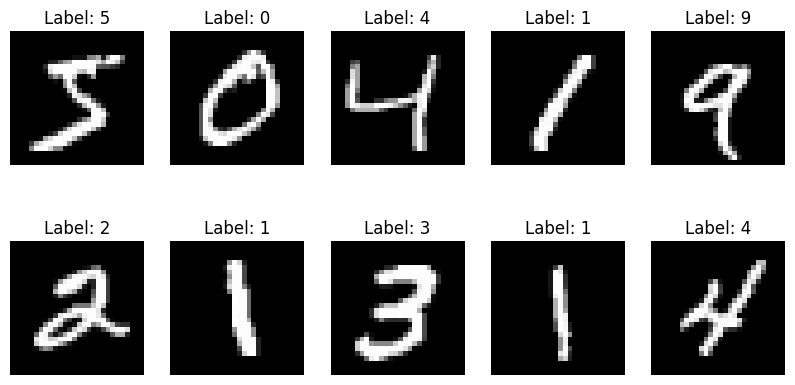

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for ax, (image, label) in zip(axes.flatten(), custom_dataset_train):
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')





##GANs Architecture



**Define the Generator class**

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )

    def forward(self, x):
        y = self.layer(x)
        y = y.view(x.size(0), 1, 28, 28)
        return y

**Define the Discriminator class**

In [ ]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y = x.view(x.size(0), -1)
        y = self.layer(y)
        return y

**Define the parameters**

In [ ]:
num_epoch = 50
step = 0
n_critic = 1
model_name = 'GAN'

**Initialize the generator and the discriminator, define loss function and optimizer:**

In [ ]:
noise = 100
D = Discriminator()
G = Generator(noise)

# Define the loss function and optimizer
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D.to(device)
G.to(device)



Generator(
  (layer): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

**Train GANs**

In [ ]:

for epoch in range(num_epoch):
    for batch_idx, (inputs, _) in enumerate(dataloader_train):
        # Training Discriminator
        x = inputs.to(device)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, noise).to(device)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        #if step % n_critic == 0:
        # Training Generator
        z = torch.randn(batch_size, noise).to(device)
        z_outputs = D(G(z))
        G_loss = criterion(z_outputs, D_labels)

        G.zero_grad()
        G_loss.backward()
        G_opt.step()

    print(f"Epoch [{epoch+1}/{num_epoch}], D Loss: {D_loss.item():.4f},  G Loss: {G_loss.item():.4f}")


Epoch [1/50], D Loss: 1.2640,  G Loss: 1.2976
Epoch [2/50], D Loss: 1.1254,  G Loss: 1.3241
Epoch [3/50], D Loss: 1.0569,  G Loss: 1.1626
Epoch [4/50], D Loss: 1.2045,  G Loss: 1.0851
Epoch [5/50], D Loss: 1.3371,  G Loss: 0.7927
Epoch [6/50], D Loss: 1.2469,  G Loss: 0.7361
Epoch [7/50], D Loss: 1.3499,  G Loss: 0.5007
Epoch [8/50], D Loss: 1.2214,  G Loss: 0.6973
Epoch [9/50], D Loss: 1.2385,  G Loss: 0.9322
Epoch [10/50], D Loss: 1.2250,  G Loss: 0.9467
Epoch [11/50], D Loss: 1.2552,  G Loss: 0.8802
Epoch [12/50], D Loss: 1.2637,  G Loss: 0.8757
Epoch [13/50], D Loss: 1.2805,  G Loss: 0.8710
Epoch [14/50], D Loss: 1.2296,  G Loss: 0.6318
Epoch [15/50], D Loss: 1.2945,  G Loss: 0.7033
Epoch [16/50], D Loss: 1.2665,  G Loss: 0.7981
Epoch [17/50], D Loss: 1.2880,  G Loss: 0.6604
Epoch [18/50], D Loss: 1.2966,  G Loss: 0.9560
Epoch [19/50], D Loss: 1.3024,  G Loss: 0.6708
Epoch [20/50], D Loss: 1.2810,  G Loss: 0.7988
Epoch [21/50], D Loss: 1.3284,  G Loss: 0.8792
Epoch [22/50], D Loss:

**Test the AutoEncoder on an image from the test set**

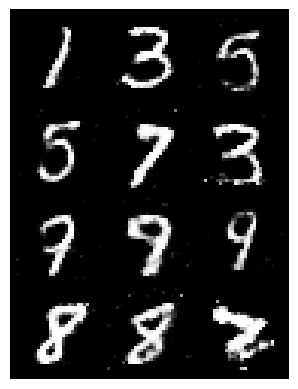

In [ ]:
# Generate random noise vectors for four images
test_batch_size = 12
z = torch.randn(test_batch_size, 100).to(device)

# Generate images using the generator
generated_images = G(z)

# Move the generated images from GPU to CPU and denormalize
generated_images_cpu = (generated_images.cpu() + 1) / 2

# Create a grid of images for visualization
grid = make_grid(generated_images_cpu.detach(), nrow=3, normalize=True)  # nrow=2 to display in 2 rows

# Convert the grid to a numpy array and display using matplotlib
grid = grid.permute(1, 2, 0).numpy()
plt.imshow(grid)
plt.axis('off')
plt.show()


In [ ]:
%%shell
jupyter nbconvert --to html GANs_implementation.ipynb

[NbConvertApp] Converting notebook task3.ipynb to html
[NbConvertApp] Writing 875227 bytes to task3.html
